In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import logging
logging.getLogger('tensorflow').disabled = True


import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

import transport_nets as tn

from transport_nets.Models.NVP import NVP
from transport_nets.bijectors import BananaMap, BananaFlow
from transport_nets.mcmc import MetropolisHastings, model_log_prob

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

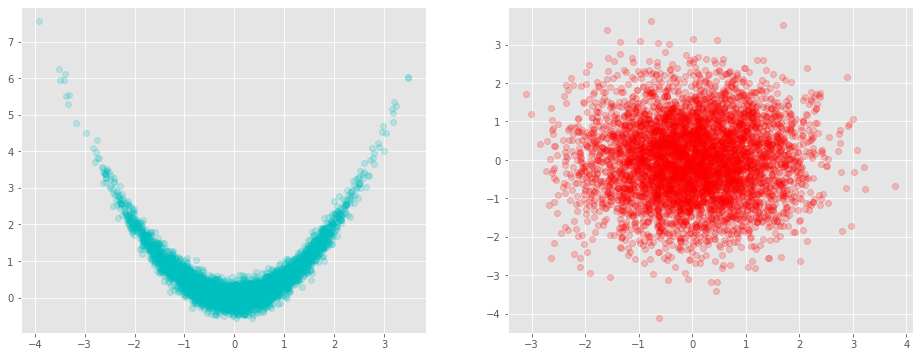

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000
bMap = BananaMap((1.0,0.5,0.2,0.0))
bFlow = BananaFlow(bMap)
target = bFlow.sample(num_samples)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

### Define an NVP-based normalizing flow

In [3]:
# Create model object
nvp = NVP(num_layers=3, neuron_list=[4,4])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=2e-3, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [4]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [5]:
# Define training options
n_epochs = 50
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 2.3694
Epoch 2/50
100/100 [==============================] - 1s 15ms/step - Negative Log Likelihood: 1.7470
Epoch 3/50
100/100 [==============================] - 2s 15ms/step - Negative Log Likelihood: 1.6036
Epoch 4/50
100/100 [==============================] - 2s 15ms/step - Negative Log Likelihood: 1.4876
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.4157
Epoch 6/50
100/100 [==============================] - 2s 15ms/step - Negative Log Likelihood: 1.3736
Epoch 7/50
100/100 [==============================] - 2s 15ms/step - Negative Log Likelihood: 1.3507
Epoch 8/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.3272
Epoch 9/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.3055
Epoch 10/50
100/100 [==============================] - 2s 15ms/step - Negative Log Likeliho

### Plot the training history

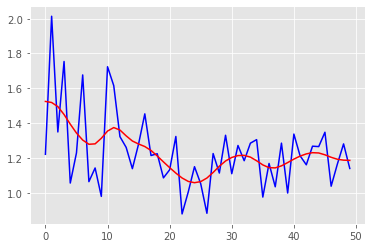

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

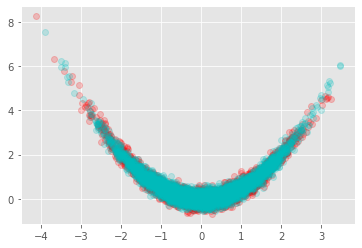

In [7]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Conditional Sampling using Metropolis Hastings

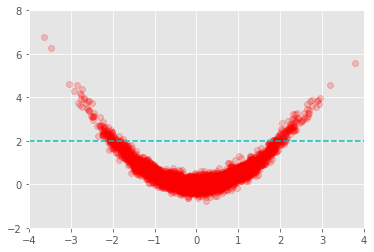

In [8]:
# We want to draw condition samples from about y = 0.0
y_star = 2.0

fig, ax = plt.subplots()
forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
ax.axhline(y=y_star, color='c', linestyle='--')
ax.set(xlim=(-4,4))
ax.set(ylim=(-2,8));

In [9]:
# Run the algorithm
init_val = tf.zeros([1],tf.float32)
b = tf.constant(2.0,tf.float32)
niters = 10000
y_given = tf.constant([2.0])
log_prob_fn = model_log_prob(nvp,y_given=y_given)

acc_rate, samples = MetropolisHastings(init_val,b,niters,log_prob_fn)
print(acc_rate)

it: 1000 time: 8.607986688613892
it: 2000 time: 7.718087434768677
it: 3000 time: 7.635323762893677
it: 4000 time: 7.6196675300598145
it: 5000 time: 7.634612560272217
it: 6000 time: 7.728728294372559
it: 7000 time: 7.860318899154663
it: 8000 time: 7.857637882232666
it: 9000 time: 7.9519031047821045
it: 10000 time: 7.990297079086304
0.0818


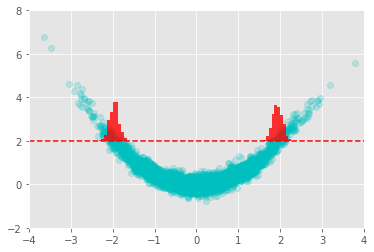

In [10]:
# Plot the conditional samples
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples[:,0], 150, (-5, 5), color='r', alpha=.8, density=True, zorder=10,bottom=2.0)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-4,4))
ax.set(ylim=(-2,8));